In [1]:
from torchsummary import summary
from datetime import datetime
import torch.nn as nn
import torch
import random
import numpy as np

from src.nn.regression_dataset import RegressionDataset
from src.nn.to_tensor import ToTensor
from src.nn.create_data_loaders import create_data_loaders
from src.nn.cnn_regressor import CNNRegressor
from src.nn.training import training
from src.nn.plot_losses import plot_losses
from src.nn.weighted_mse_loss import WeightedMSELoss
import src.ctes.num_ctes as nctes
import src.ctes.path_ctes as pctes

In [2]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
data_path = pctes.DATAPATH
transform = ToTensor()
sample_size = nctes.LEN_SAMPLE

data = RegressionDataset(data_path, transform, sample_size)

In [4]:
batch_size = 6
valid_size = 0.2
test_size = 0.2

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


In [61]:
sample_size = nctes.LEN_SAMPLE
dropout_probs=[0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7]
model = CNNRegressor(input_size=sample_size, dropout_probs=dropout_probs)
model.to(device=device)

summary(model, (1, sample_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Dropout: 1-2                           [-1, 16, 32768]           --
├─Sequential: 1-3                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-4                         [-1, 32, 16384]           --
├─Dropout: 1-5                           [-1, 32, 16384]           --
├─Sequential: 1-6                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─Ba

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Dropout: 1-2                           [-1, 16, 32768]           --
├─Sequential: 1-3                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-4                         [-1, 32, 16384]           --
├─Dropout: 1-5                           [-1, 32, 16384]           --
├─Sequential: 1-6                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─Ba

In [62]:
#weights = torch.tensor(1.5, 1.5, 1.0, 1.0])
#criterion = WeightedMSELoss(weights)
criterion = nn.MSELoss()
print(criterion)

MSELoss()


In [63]:
model_name = "Variable dropout probas and L2 regularization" # name given to the trained model

In [64]:
params = model.parameters()
lr = 0.001
weight_decay = 1e-5 # for L2 regularization (remove the line and the argument in optimizer if L2 reg not needed)

optimizer = torch.optim.Adam(params, lr, weight_decay = weight_decay)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)


In [65]:
n_epochs = 100

In [66]:
timestamp = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
hyperparams_path = f"../../data/hyperparams_{timestamp}.npz"
model_path = f"../../data/model_{timestamp}.pt"
losses_path = f"../../data/losses_{timestamp}.npz"

In [67]:
np.savez(hyperparams_path, 
         len=len(data), 
         test_size=test_size, 
         valid_size=valid_size, 
         epochs=n_epochs, 
         batch_size=batch_size, 
         criterion=str(criterion), 
         optimizer=str(optimizer), 
         lr=lr,
         seed=seed,
         weight_decay = weight_decay,
         dropout_probs = dropout_probs, 
         model_name = model_name)

In [12]:
train_losses, valid_losses = training(n_epochs, train_loader, valid_loader, model, criterion, optimizer, device, model_path)

Epoch 1/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.45it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.75it/s]


Epoch: 1 	training Loss: 0.184484 	validation Loss: 0.132075
Validation loss decreased (inf --> 0.132075).  Saving model ...
Epoch 2/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:45<00:00,  8.25it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.70it/s]


Epoch: 2 	training Loss: 0.134985 	validation Loss: 0.131390
Validation loss decreased (0.132075 --> 0.131390).  Saving model ...
Epoch 3/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:45<00:00,  8.24it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.72it/s]


Epoch: 3 	training Loss: 0.133854 	validation Loss: 0.131555
Epoch 4/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:45<00:00,  8.23it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.71it/s]


Epoch: 4 	training Loss: 0.133134 	validation Loss: 0.131588
Epoch 5/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:45<00:00,  8.24it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.67it/s]


Epoch: 5 	training Loss: 0.132464 	validation Loss: 0.131380
Validation loss decreased (0.131390 --> 0.131380).  Saving model ...
Epoch 6/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:45<00:00,  8.24it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.71it/s]


Epoch: 6 	training Loss: 0.132051 	validation Loss: 0.131275
Validation loss decreased (0.131380 --> 0.131275).  Saving model ...
Epoch 7/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:45<00:00,  8.26it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.72it/s]


Epoch: 7 	training Loss: 0.131973 	validation Loss: 0.131186
Validation loss decreased (0.131275 --> 0.131186).  Saving model ...
Epoch 8/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:43<00:00,  8.38it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.73it/s]


Epoch: 8 	training Loss: 0.131973 	validation Loss: 0.131183
Validation loss decreased (0.131186 --> 0.131183).  Saving model ...
Epoch 9/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:43<00:00,  8.37it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.70it/s]


Epoch: 9 	training Loss: 0.131970 	validation Loss: 0.131209
Epoch 10/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:43<00:00,  8.37it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.71it/s]


Epoch: 10 	training Loss: 0.131974 	validation Loss: 0.131140
Validation loss decreased (0.131183 --> 0.131140).  Saving model ...
Epoch 11/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.44it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.77it/s]


Epoch: 11 	training Loss: 0.131973 	validation Loss: 0.131234
Epoch 12/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.45it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.82it/s]


Epoch: 12 	training Loss: 0.131970 	validation Loss: 0.131162
Epoch 13/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:42<00:00,  8.43it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.70it/s]


Epoch: 13 	training Loss: 0.132010 	validation Loss: 0.131248
Epoch 14/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.47it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.92it/s]


Epoch: 14 	training Loss: 0.131952 	validation Loss: 0.131254
Epoch 15/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.47it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.91it/s]


Epoch: 15 	training Loss: 0.131982 	validation Loss: 0.131181
Epoch 16/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.48it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.85it/s]


Epoch: 16 	training Loss: 0.132006 	validation Loss: 0.131215
Epoch 17/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.03it/s]


Epoch: 17 	training Loss: 0.131963 	validation Loss: 0.131242
Epoch 18/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.01it/s]


Epoch: 18 	training Loss: 0.131968 	validation Loss: 0.131225
Epoch 19/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.51it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.95it/s]


Epoch: 19 	training Loss: 0.131964 	validation Loss: 0.131174
Epoch 20/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.51it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.08it/s]


Epoch: 20 	training Loss: 0.131980 	validation Loss: 0.131234
Epoch 21/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.52it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.05it/s]


Epoch: 21 	training Loss: 0.131959 	validation Loss: 0.131206
Epoch 22/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.53it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.91it/s]


Epoch: 22 	training Loss: 0.131968 	validation Loss: 0.131246
Epoch 23/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.52it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.03it/s]


Epoch: 23 	training Loss: 0.131978 	validation Loss: 0.131188
Epoch 24/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.52it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.95it/s]


Epoch: 24 	training Loss: 0.131982 	validation Loss: 0.131207
Epoch 25/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.54it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.02it/s]


Epoch: 25 	training Loss: 0.131964 	validation Loss: 0.131170
Epoch 26/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.54it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.10it/s]


Epoch: 26 	training Loss: 0.131982 	validation Loss: 0.131207
Epoch 27/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.55it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.10it/s]


Epoch: 27 	training Loss: 0.131965 	validation Loss: 0.131163
Epoch 28/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.54it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.01it/s]


Epoch: 28 	training Loss: 0.131968 	validation Loss: 0.131201
Epoch 29/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.53it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.94it/s]


Epoch: 29 	training Loss: 0.131982 	validation Loss: 0.131274
Epoch 30/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.51it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.06it/s]


Epoch: 30 	training Loss: 0.131975 	validation Loss: 0.131181
Epoch 31/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.51it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.92it/s]


Epoch: 31 	training Loss: 0.131967 	validation Loss: 0.131253
Epoch 32/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.89it/s]


Epoch: 32 	training Loss: 0.131994 	validation Loss: 0.131266
Epoch 33/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.91it/s]


Epoch: 33 	training Loss: 0.131989 	validation Loss: 0.131185
Epoch 34/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.48it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.85it/s]


Epoch: 34 	training Loss: 0.131973 	validation Loss: 0.131212
Epoch 35/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.47it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.04it/s]


Epoch: 35 	training Loss: 0.131967 	validation Loss: 0.131207
Epoch 36/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.47it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.02it/s]


Epoch: 36 	training Loss: 0.131968 	validation Loss: 0.131181
Epoch 37/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.47it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.80it/s]


Epoch: 37 	training Loss: 0.131982 	validation Loss: 0.131206
Epoch 38/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.48it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.92it/s]


Epoch: 38 	training Loss: 0.131963 	validation Loss: 0.131196
Epoch 39/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.47it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.98it/s]


Epoch: 39 	training Loss: 0.131983 	validation Loss: 0.131227
Epoch 40/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.46it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.04it/s]


Epoch: 40 	training Loss: 0.131960 	validation Loss: 0.131155
Epoch 41/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.46it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.92it/s]


Epoch: 41 	training Loss: 0.131967 	validation Loss: 0.131188
Epoch 42/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.47it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.93it/s]


Epoch: 42 	training Loss: 0.131968 	validation Loss: 0.131168
Epoch 43/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.45it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.85it/s]


Epoch: 43 	training Loss: 0.131959 	validation Loss: 0.131231
Epoch 44/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.47it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.02it/s]


Epoch: 44 	training Loss: 0.131980 	validation Loss: 0.131196
Epoch 45/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.47it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.03it/s]


Epoch: 45 	training Loss: 0.131960 	validation Loss: 0.131260
Epoch 46/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.47it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 25.98it/s]


Epoch: 46 	training Loss: 0.131969 	validation Loss: 0.131171
Epoch 47/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.09it/s]


Epoch: 47 	training Loss: 0.131970 	validation Loss: 0.131206
Epoch 48/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.18it/s]


Epoch: 48 	training Loss: 0.131964 	validation Loss: 0.131179
Epoch 49/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.21it/s]


Epoch: 49 	training Loss: 0.131968 	validation Loss: 0.131230
Epoch 50/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.25it/s]


Epoch: 50 	training Loss: 0.131960 	validation Loss: 0.131287
Epoch 51/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.51it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.14it/s]


Epoch: 51 	training Loss: 0.131977 	validation Loss: 0.131217
Epoch 52/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.25it/s]


Epoch: 52 	training Loss: 0.131966 	validation Loss: 0.131154
Epoch 53/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.17it/s]


Epoch: 53 	training Loss: 0.131964 	validation Loss: 0.131263
Epoch 54/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.18it/s]


Epoch: 54 	training Loss: 0.131964 	validation Loss: 0.131209
Epoch 55/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.17it/s]


Epoch: 55 	training Loss: 0.131965 	validation Loss: 0.131182
Epoch 56/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.17it/s]


Epoch: 56 	training Loss: 0.131967 	validation Loss: 0.131164
Epoch 57/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.28it/s]


Epoch: 57 	training Loss: 0.131968 	validation Loss: 0.131280
Epoch 58/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.25it/s]


Epoch: 58 	training Loss: 0.131960 	validation Loss: 0.131196
Epoch 59/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.12it/s]


Epoch: 59 	training Loss: 0.131971 	validation Loss: 0.131287
Epoch 60/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.51it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.22it/s]


Epoch: 60 	training Loss: 0.131972 	validation Loss: 0.131241
Epoch 61/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.19it/s]


Epoch: 61 	training Loss: 0.131957 	validation Loss: 0.131234
Epoch 62/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.11it/s]


Epoch: 62 	training Loss: 0.131966 	validation Loss: 0.131188
Epoch 63/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.51it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.14it/s]


Epoch: 63 	training Loss: 0.131966 	validation Loss: 0.131248
Epoch 64/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.21it/s]


Epoch: 64 	training Loss: 0.131968 	validation Loss: 0.131200
Epoch 65/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.21it/s]


Epoch: 65 	training Loss: 0.131957 	validation Loss: 0.131239
Epoch 66/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.09it/s]


Epoch: 66 	training Loss: 0.131972 	validation Loss: 0.131254
Epoch 67/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.47it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.17it/s]


Epoch: 68 	training Loss: 0.131974 	validation Loss: 0.131251
Epoch 69/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.51it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.09it/s]


Epoch: 69 	training Loss: 0.131949 	validation Loss: 0.131191
Epoch 70/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.51it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.26it/s]


Epoch: 70 	training Loss: 0.131972 	validation Loss: 0.131160
Epoch 71/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.23it/s]


Epoch: 71 	training Loss: 0.131962 	validation Loss: 0.131209
Epoch 72/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.23it/s]


Epoch: 72 	training Loss: 0.131973 	validation Loss: 0.131232
Epoch 73/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.25it/s]


Epoch: 73 	training Loss: 0.131963 	validation Loss: 0.131220
Epoch 74/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.17it/s]


Epoch: 74 	training Loss: 0.131966 	validation Loss: 0.131183
Epoch 75/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.23it/s]


Epoch: 75 	training Loss: 0.131973 	validation Loss: 0.131192
Epoch 76/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.24it/s]


Epoch: 76 	training Loss: 0.131967 	validation Loss: 0.131215
Epoch 77/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.17it/s]


Epoch: 77 	training Loss: 0.131966 	validation Loss: 0.131260
Epoch 78/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.16it/s]


Epoch: 78 	training Loss: 0.131957 	validation Loss: 0.131193
Epoch 79/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.48it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.12it/s]


Epoch: 79 	training Loss: 0.131972 	validation Loss: 0.131164
Epoch 80/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.15it/s]


Epoch: 80 	training Loss: 0.131959 	validation Loss: 0.131304
Epoch 81/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.12it/s]


Epoch: 81 	training Loss: 0.131959 	validation Loss: 0.131203
Epoch 82/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.21it/s]


Epoch: 82 	training Loss: 0.131963 	validation Loss: 0.131255
Epoch 83/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.23it/s]


Epoch: 83 	training Loss: 0.131970 	validation Loss: 0.131206
Epoch 84/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.22it/s]


Epoch: 84 	training Loss: 0.131960 	validation Loss: 0.131170
Epoch 85/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.24it/s]


Epoch: 85 	training Loss: 0.131972 	validation Loss: 0.131182
Epoch 86/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.22it/s]


Epoch: 86 	training Loss: 0.131975 	validation Loss: 0.131186
Epoch 87/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.50it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.13it/s]


Epoch: 87 	training Loss: 0.131964 	validation Loss: 0.131155
Epoch 88/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:41<00:00,  8.48it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.09it/s]


Epoch: 88 	training Loss: 0.131967 	validation Loss: 0.131219
Epoch 89/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:42<00:00,  8.41it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.09it/s]


Epoch: 89 	training Loss: 0.131978 	validation Loss: 0.131210
Epoch 90/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.51it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.20it/s]


Epoch: 90 	training Loss: 0.131967 	validation Loss: 0.131165
Epoch 91/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:40<00:00,  8.54it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.29it/s]


Epoch: 91 	training Loss: 0.131964 	validation Loss: 0.131178
Epoch 92/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.54it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:12<00:00, 26.38it/s]


Epoch: 92 	training Loss: 0.131957 	validation Loss: 0.131184
Epoch 93/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.56it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:13<00:00, 26.23it/s]


Epoch: 93 	training Loss: 0.131956 	validation Loss: 0.131211
Epoch 94/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.57it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:12<00:00, 26.41it/s]


Epoch: 94 	training Loss: 0.131961 	validation Loss: 0.131178
Epoch 95/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.58it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:12<00:00, 26.32it/s]


Epoch: 95 	training Loss: 0.131958 	validation Loss: 0.131199
Epoch 96/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.58it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:12<00:00, 26.44it/s]


Epoch: 96 	training Loss: 0.131967 	validation Loss: 0.131198
Epoch 97/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.57it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:12<00:00, 26.32it/s]


Epoch: 97 	training Loss: 0.131962 	validation Loss: 0.131223
Epoch 98/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.58it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:12<00:00, 26.40it/s]


Epoch: 98 	training Loss: 0.131982 	validation Loss: 0.131201
Epoch 99/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.58it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:12<00:00, 26.43it/s]


Epoch: 99 	training Loss: 0.131968 	validation Loss: 0.131252
Epoch 100/100 ...
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1366/1366 [02:39<00:00,  8.58it/s]


Validating ...


100%|██████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:12<00:00, 26.46it/s]

Epoch: 100 	training Loss: 0.131963 	validation Loss: 0.131179


In [13]:
np.savez(losses_path , train=np.array(train_losses), val=np.array(valid_losses))

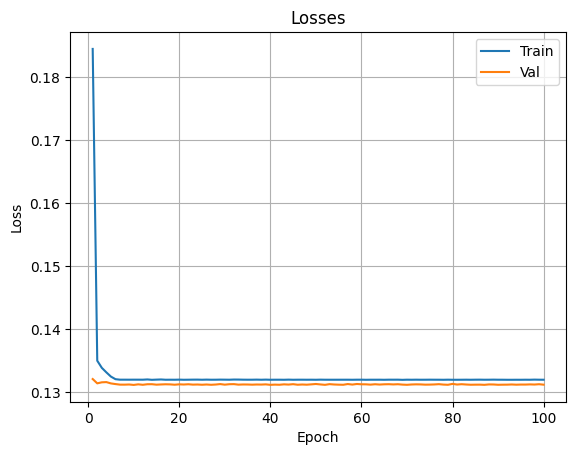

In [14]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])